# **Calibrate Vicon coordinates to 3dMD coordinates**

$$\bm{x}_{3dmd} = s \bm{R} \bm{x}_{vicon} + \bm{t}$$

If only want to dry-run, set `is_output` as `False`.

Otherwise, the calibration parameters will be outputted to `mesh4d/config/calibrate/` folder:

| Variables | Contents                                |
| --------- | --------------------------------------- |
| `s.npy`   | Storing the scaling rate $s$.           |
| `r.npy`   | Storing the rotation matrix $\bm R$.    |
| `t.npy`   | Storing the translation vector $\bm t$. |

_P.S. Before calibration, 3dMD mesh, key points extracted from 3dMD mesh, and corresponding Vicon key points data need to be prepared. Noted that the key points from 3dMD mesh is extracted with `kps_extract.py` and saved as `points_3dmd.npy`._

In [1]:
# is_output = True
is_output = False

# Preparation and Data Loading

Variables related to 3dMD system:

| Variables     | Contents                                                    |
| ------------- | ----------------------------------------------------------- |
| `points_3dmd` | Loaded key points from 3dMD system as `numpy` (N, 3) array. |
| `pcd_3dmd`    | Loaded key point converted as `open3d` point cloud.         |
| `pvpcd_3dmd`  | Loaded key point converted as `pyvista` point cloud.        |

Variables related to Vicon system:

| Variables      | Contents                                                     |
| -------------- | ------------------------------------------------------------ |
| `points_vicon` | Loaded key points from Vicon system as `numpy` (N, 3) array. |
| `pcd_vicon`    | Loaded key point converted as `open3d` point cloud.          |
| `pvpcd_vicon`  | Loaded key point converted as `pyvista` point cloud.         |

In [2]:
# add root folder of the project to path
import sys
sys.path.insert(0, '../../..')

In [3]:
# load markers
import numpy as np
points_3dmd = np.load('../../config/calibrate/points_3dmd.npy')

from mesh4d import obj3d
pcd_3dmd = obj3d.np2pcd(points_3dmd)

In [4]:
# load kps
from mesh4d import kps
vicon = kps.MarkerSet()
vicon.load_from_vicon('../../../data/landmarks/static_3markers.csv', convert=False)

# some silly format issue was found in the csv file lol orz...
vicon.markers = {
    'Bra_Miss Sun:C7': vicon.markers['Bra_Miss Sun:C7'],
    'Bra_Miss Sun:T10': vicon.markers['Bra_Miss Sun:T10'],
    'Bra_Miss Sun:CLAV': vicon.markers['Bra_Miss Sun:CLAV'],
}

vicon.interp_field()

points_vicon = vicon.get_frame_coord(0).get_points_coord()
pcd_vicon = obj3d.np2pcd(points_vicon)

calibration parameters loaded
error happended when loading kps file: column Trajectory Count.1
error happended when loading kps file: column Trajectory Count.2
loaded 1 vicon file: ../../../data/landmarks/static_3markers.csv


In [5]:
points_vicon, points_3dmd

(array([[  27.270815,  -31.203543, 1401.304932],
        [ -60.131954,  -70.042122, 1116.331909],
        [  89.845589,  -91.946724, 1120.162842]]),
 array([[-10.18279539, 854.56274138,  37.68072221],
        [-94.09651767, 570.02232857,  56.2605112 ],
        [ 52.54595752, 576.97629618,  84.49949104]]))

In [6]:
# pcd_vicon
pcd_3dmd

PointCloud with 3 points.

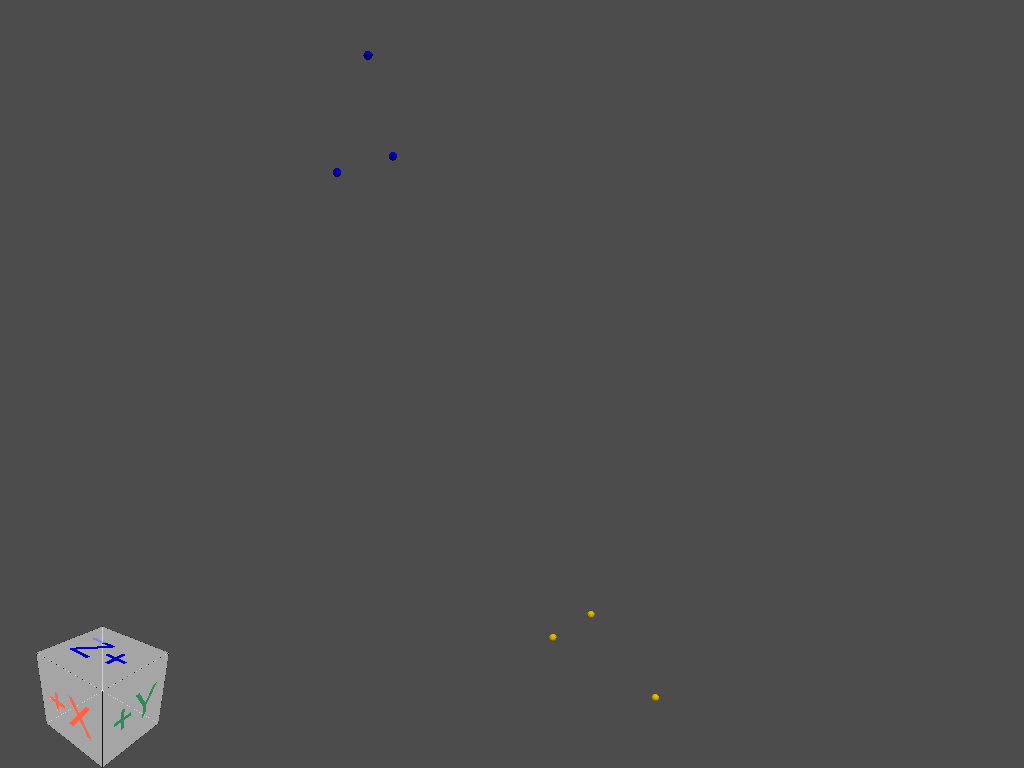

In [7]:
# plot point clouds before calibration
import pyvista as pv
pv.set_jupyter_backend('static')

pvpcd_3dmd = obj3d.np2pvpcd(points_3dmd, radius=10, phi_resolution=10, theta_resolution=10)
pvpcd_vicon = obj3d.np2pvpcd(points_vicon, radius=10, phi_resolution=10, theta_resolution=10)

scene = pv.Plotter()
scene.add_mesh(pvpcd_3dmd, color='Gold')
scene.add_mesh(pvpcd_vicon, color='Blue')
scene.add_axes(box=True)
scene.show()

# Pre-alignment and Calibration

To facilitate accurate calibration, manual pre-alignment (rotation `r_pre`) is implemented to Vicon key points and yields:

| Variables          | Contents                                                |
| ------------------ | ------------------------------------------------------- |
| `points_vicon_pre` | Pre-aligned Vicon key points as `numpy` (N, 3) array    |
| `pcd_vicon_pre`    | Pre-aligned Vicon point cloud as `open3d` point cloud.  |
| `pvpcd_vicon_pre`  | Pre-aligned Vicon point cloud as `pyvista` point cloud. |

And then the Vicon key points is calibrate with 3dMD key points:

| Variables | Contents                          |
| --------- | --------------------------------- |
| `r_cab`   | The estimated rotation matrix.    |
| `s`       | The estimated scaling rate.       |
| `t`       | The estimated translation vector. |

The estimated calibration parameters are applied to the pre-aligned Vicon point cloud and yields:

| Variables          | Contents                                                |
| ------------------ | ------------------------------------------------------- |
| `points_vicon_cab` | Calibrated Vicon key points as `numpy` (N, 3) array    |
| `pvpcd_vicon_cab`  | Calibrated Vicon point cloud as `pyvista` point cloud. |

In [8]:
# pre-alignment
import copy
pcd_vicon_pre = copy.deepcopy(pcd_vicon)
r_pre = pcd_vicon_pre.get_rotation_matrix_from_xyz((-np.pi/2, 0, 0))
pcd_vicon_pre.rotate(r_pre, center=(0, 0, 0))
points_vicon_pre = obj3d.pcd2np(pcd_vicon_pre)

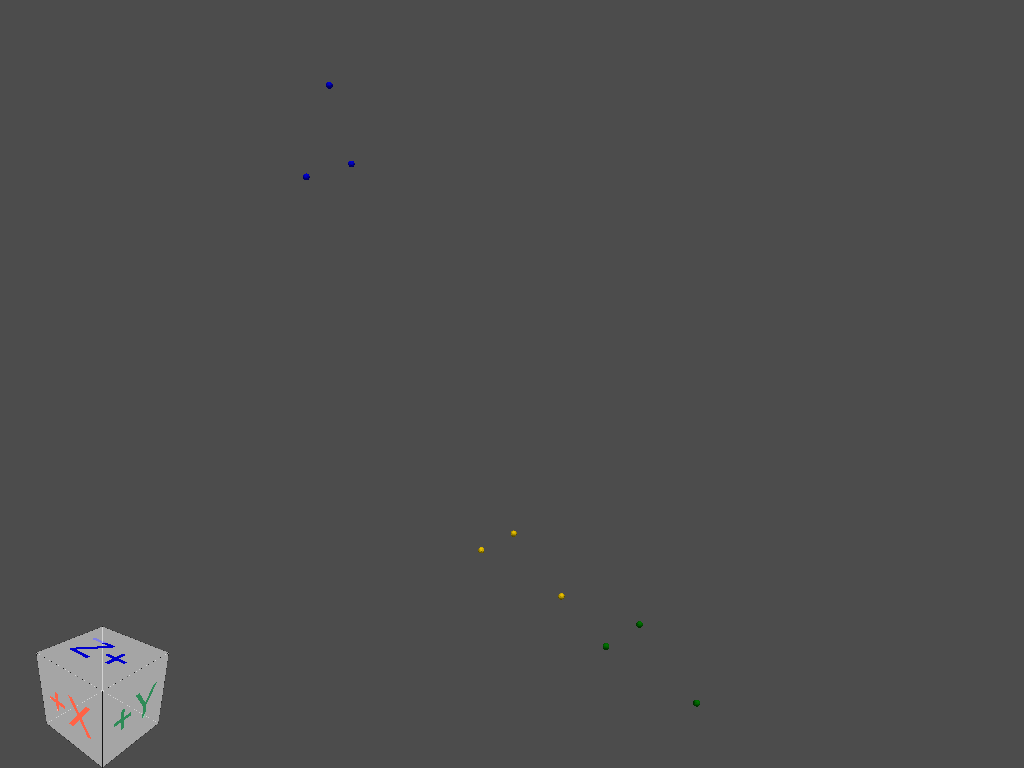

In [9]:
# plot point clouds after pre-alignment
pvpcd_vicon_pre = obj3d.np2pvpcd(points_vicon_pre, radius=10, phi_resolution=10, theta_resolution=10)

scene = pv.Plotter()
scene.add_mesh(pvpcd_vicon_pre, color='Green')
scene.add_mesh(pvpcd_3dmd, color='Gold')
scene.add_mesh(pvpcd_vicon, color='Blue')
scene.add_axes(box=True)
scene.show()

In [10]:
# cpd rigid registration
from probreg import cpd
tf_param, _, _ = cpd.registration_cpd(
    pcd_vicon_pre, pcd_3dmd, 'rigid', maxiter=int(1e5), tol=1e-5,# update_scale=False,
)

r_cab = tf_param.rot
s = tf_param.scale
t = tf_param.t

points_vicon_cab = tf_param.transform(points_vicon_pre)

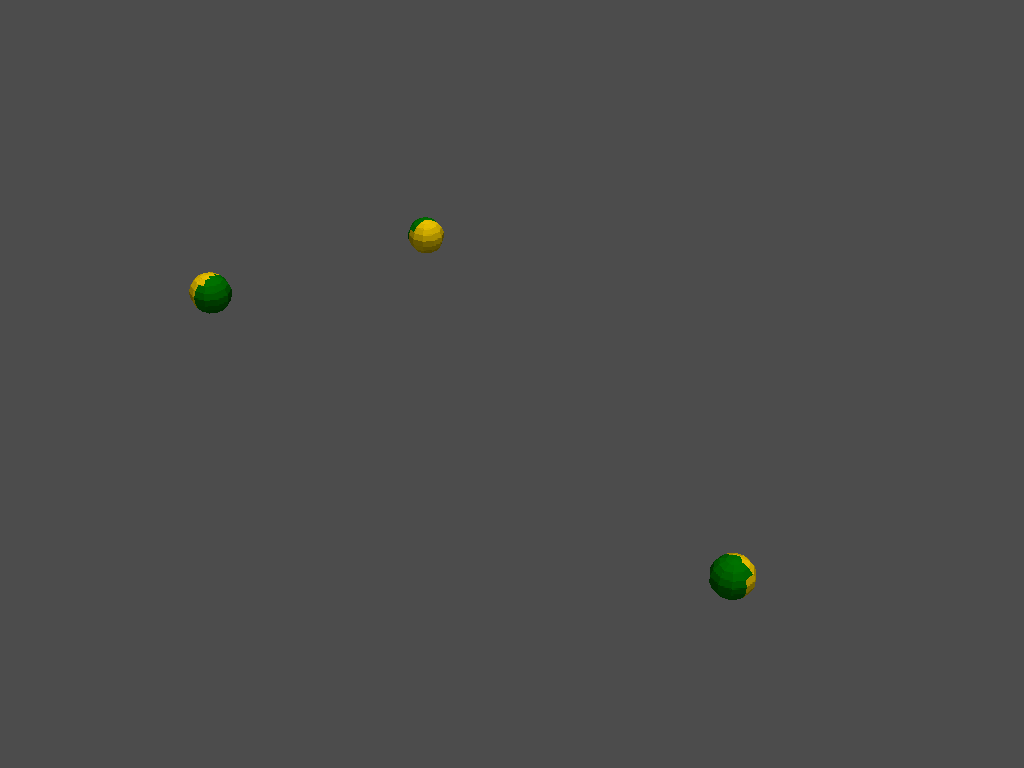

In [11]:
# plot point clouds after calibration
# points_3dmd_cab = obj3d.pcd2np(pcd_3dmd_cab)
pvpcd_vicon_cab = obj3d.np2pvpcd(points_vicon_cab, radius=10, phi_resolution=10, theta_resolution=10)

scene = pv.Plotter()
scene.add_mesh(pvpcd_vicon_cab, color='Gold')
scene.add_mesh(pvpcd_3dmd, color='Green')
scene.show()

# Calibration Validation

In previous steps, pre-alignment rotation `r_pre` and the estimated rotation `r_cab` are all implemented:

$$\bm{x}_{3dmd} = s \bm{R}_{cab} [\bm{R}_{pre} \bm{x}_{vicon}] + \bm{t}
= s [\bm{R}_{cab} \bm{R}_{pre}] \bm{x}_{vicon} + \bm{t}$$

Therefore, their mutual effects are calculated as $\bm{R} = \bm{R}_{cab} \bm{R}_{pre}$ stored as `r`, leading to the complete calibration parameters:

| Variables | Contents                        |
| --------- | ------------------------------- |
| `s`       | The scaling rate $s$.           |
| `r`       | The rotation matrix $\bm R$.    |
| `t`       | The translation vector $\bm t$. |

_P.S. About the combined parameter $\bm M$: [Spatial Transformation Matrices - Rainer Goebel](https://www.brainvoyager.com/bv/doc/UsersGuide/CoordsAndTransforms/SpatialTransformationMatrices.html)_

$$\mathcal T(\bm{x}) = s \bm{R} \bm{x} + \bm{t} = s \bm{M} \bm{x}$$

To verify its effectiveness, these parameters are applied to the original Vicon point cloud and plotted together with the 3dMD mesh & key points:

| Variables         | Contents                                                         |
| ----------------- | ---------------------------------------------------------------- |
| `mesh`            | 3dMD mesh loaded with `pyvista`.                                 |
| `texture`         | 3dMD mesh texture loaded with `pyvista`.                         |
| `pvpcd_vicon_val` | Validation calibrated Vicon point cloud as `open3d` point cloud. |

In [12]:
# combine pre-alignment and registration
r = np.matmul(r_cab, r_pre)

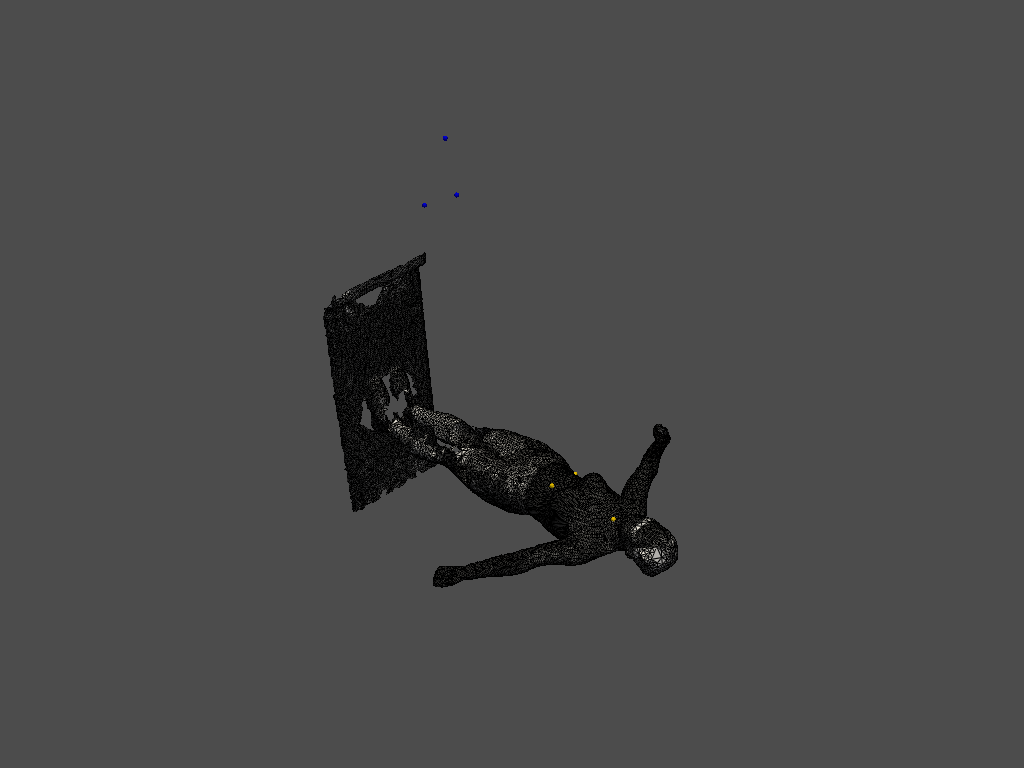

In [13]:
# plot 3dmd data before calibrating to vicon
mesh = pv.read('../../../data/meshes/static_3markers/static_standing.000001.obj')
texture = pv.read_texture('../../../data/meshes/static_3markers/static_standing.000001.jpg')

scene = pv.Plotter()
scene.add_mesh(mesh, show_edges=True)
scene.add_mesh(pvpcd_3dmd, color='Gold')
scene.add_mesh(pvpcd_vicon, color='Blue')
scene.show()

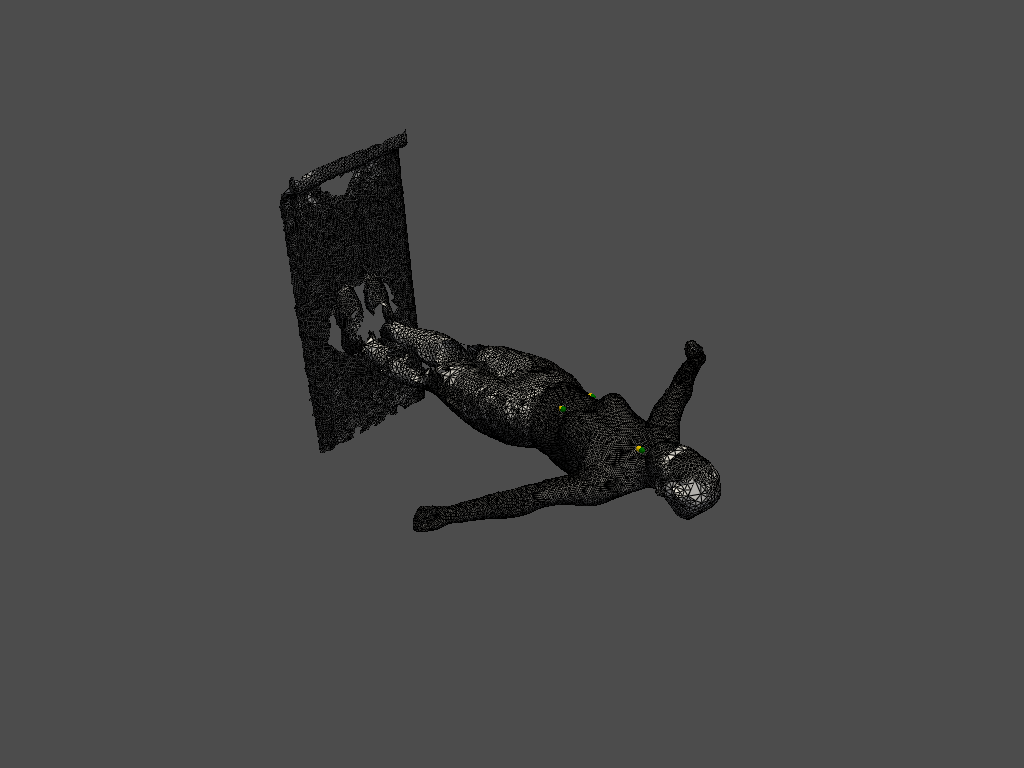

In [14]:
# plot 3dmd data after calibrating to vicon
from mesh4d import field
s, m = field.transform_rst2sm(r, s, t)

pvpcd_vicon_val = copy.deepcopy(pvpcd_vicon)
pvpcd_vicon_val.transform(m)
pvpcd_vicon_val.scale(s)

scene = pv.Plotter()
scene.add_mesh(mesh, show_edges=True)
scene.add_mesh(pvpcd_3dmd, color='Gold')
scene.add_mesh(pvpcd_vicon_val, color='Green')
scene.show()

# Parameter Saving

If `is_output` is set as `True`, the calibration parameters will be outputted to `mesh4d/config/calibrate/` folder:

| Variables | Contents                                |
| --------- | --------------------------------------- |
| `s.npy`   | Storing the scaling rate $s$.           |
| `r.npy`   | Storing the rotation matrix $\bm R$.    |
| `t.npy`   | Storing the translation vector $\bm t$. |

In [15]:
# save parameters
if is_output:
    np.save('r', r)
    np.save('s', s)
    np.save('t', t)

P.S. Comparison of two calibrations based on _6km/h running data_ and _static standing_ data

In [16]:
r, np.load('legacy/r.npy')

(array([[ 0.99884686,  0.04494361, -0.01688256],
        [ 0.01434727,  0.05614733,  0.9983194 ],
        [ 0.04581599, -0.99741042,  0.05543776]]),
 array([[ 0.97596883,  0.19838636, -0.09015376],
        [ 0.12082303, -0.14835325,  0.98152591],
        [ 0.18134675, -0.96883134, -0.16875779]]))

In [17]:
s, np.load('legacy/s.npy')

(0.9845805672618684, array(0.95665592))

In [18]:
t, np.load('legacy/t.npy')

(array([ -12.91906155, -521.41703203,  -70.80417767]),
 array([  15.42358446, -414.9979231 ,  157.55436241]))